# Univariate Time Series Prediction

We take the Air Passenger data set that is available on kaggle and also included in this github repo.  
It is a simple seasonal data set with a clear upward trend. 

This sheet is in constant development. For the start however we will focus on the most intuitive and easy prediction techniques

Classical approaches
* SARIMAX (we won't use the X that is exagenous data)
* Holt-Winter (triple exponential smoothing)

Deep learning approaches 
* Dense Neural Network (FNN)
* classical LSTM network 

Later we will add
* Auto-Encoder POC 
* Seq2Seq 

For the "Later" section we will use the SARIMAX and HW predicitons as baseline since they are pretty good in matching this data set. The goal is to do many POC and learn from it since there are multiple types of Auto Encoder and Seq2Seq for Time Series data

### data preparation
First seperate data into train and test set before looking at it entirely

,#Passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


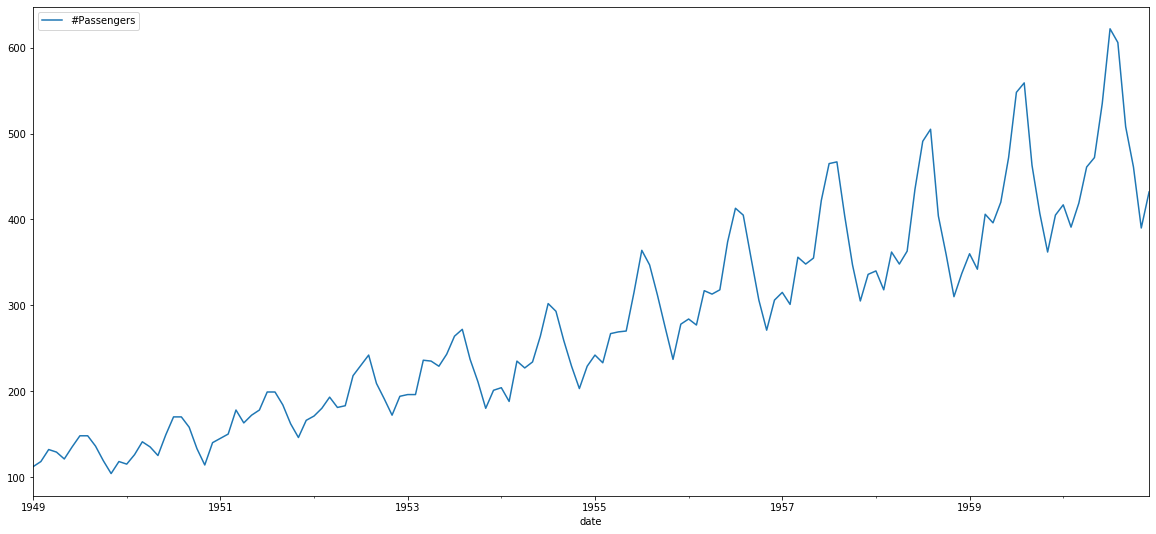

In [2]:
import pandas as pd

df = pd.read_csv("datasets_1057_1913_AirPassengers.csv")
df["date"] = pd.to_datetime(df["Month"].apply(lambda x: x+"-01"))

df = df.drop(["Month"],axis=1)
df = df.set_index("date")

df.plot(figsize=(20,9))

# use 20% of the data for testing
sentinel = int(.8 * len(df.index))


df_train = df.iloc[:sentinel,:]
df_test = df.iloc[sentinel:,:]

df_train.head()


**Observations:**  
The data contains around 11 years of data and clearly a trend and the seasonality is showing.

We will further investigate by decompose this.


t


<Figure size 1440x720 with 0 Axes>

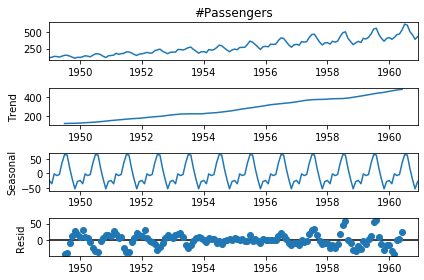

In [78]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(df["#Passengers"])
plt.figure(figsize=(20,10))
res.plot()
print("t")

**Observations:**

Here we can clearly see that the trend is almost linear and not very comples at all. The Seasonality is also very visible. 
The residuals look a bit trending on the end from year 1957 on since we have these outliers to the top that don't exist for the rest of the years.



### Applying SARIMA

We will commence by doing the usual SARIMA analyses. Here are the bulletpoints that I always do when looking at Time Series analysis for SARIMA

* have a look at the decompose: already done, looks promising
* check for stationarity by diff and diff log the original data series, test with Augmented Dickey-Fuller  
  ADF H0 is "data is not stationary", we can reject with p<0.05
* look at ACF and PACF to guess seasonality and p,q,P,Q parameters,  d derives from diff testing before
* GridSearch best parameters by  using Bayess Information Criterion, (use Ljung–Box test, we don't want to reject H0) 
* Apply Cross Validate Scoring (for Timeseries)
* Validate on Test data set and derive baseline error, RMSE 

In [3]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as st
import math
import warnings 
from statsmodels.tsa.holtwinters import ExponentialSmoothing
warnings.simplefilter('ignore')

# functions
def test_stationarity(timeseries, col, win):
    movingAverage = timeseries.rolling(window=win).mean()
    movingSTD = timeseries.rolling(window=win).std()

    orig = plt.plot(timeseries, color="blue", label="Original")
    mean = plt.plot(movingAverage, color ="red", label="Rolling Mean")
    std = plt.plot(movingSTD, color = "black", label = "Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean & Standard Deviation")
    plt.show(block=True)

    dftest = adfuller(timeseries[col], autolag="AIC")

    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic","p-value","#Lags Used","Number of Observations Used"])
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    print(dfoutput)
    
def plots(df):
    
    ax1 = plt.subplot(311)
    
    df.plot(ax=ax1)
    
    #ax2 = plt.subplot(312)
    #plot_acf(df, lags=40, ax=ax2, zero=False)
    
    #ax3 = plt.subplot(313)
    #plot_pacf(df, lags=40, ax=ax3, zero=False)
    
    lag_acf = acf(df, nlags=min(40,len(df.index)-2))
    lag_pacf = pacf(df, nlags=min(40,len(df.index)-2),method='ols')
    
    ax2 = plt.subplot(312)
    ax2.stem(lag_acf)
    ax2.axhline(y=0,linestyle="--",color="gray")
    ax2.axhline(y=-1.96/np.sqrt(len(df)), linestyle="--",color="gray")
    ax2.axhline(y=1.96/np.sqrt(len(df)), linestyle="--",color="gray")
    ax2.title.set_text("ACF")
    
    
    ax3 = plt.subplot(313)
    ax3.stem(lag_pacf)
    ax3.axhline(y=0,linestyle="--",color="gray")
    ax3.axhline(y=-1.96/np.sqrt(len(df)), linestyle="--",color="gray")
    ax3.axhline(y=1.96/np.sqrt(len(df)), linestyle="--",color="gray")
    ax3.title.set_text("PACF")
    
    f = plt.gcf()
    f.set_figheight(15)
    f.set_figwidth(15)
    
    
def cust_sarimax(df,p,d,q,P,D,Q,s,maxorder=6):
    min = 200000000
    minp=minq=mind=minD=minP=minQ=mins = 2000000
    strmin = ""
    for _p in p:
        for _q in q:
            for _d in d:
                for _D in D:
                    for _P in P:
                        for _Q in Q:
                            for _s in s:
                                try:
                                    if _p + _q + _d + _P + _D + _Q <= maxorder:
                                        model = SARIMAX(df, order=(_p,_d,_q) , seasonal_order=(_P,_D,_Q,_s), enforce_invertibility= False, enforce_stationarity=False)
                                        model_result = model.fit(disp=0)
                                        SSE = np.sum(model_result.resid**2)
                                        pvals = acorr_ljungbox(model_result.resid, lags=math.ceil(math.log(len(model_result.resid))))[1]
                                        curstr = str(_p)+" "+str(_d)+" "+str(_q)+" "+str(_P)+" "+str(_D)+" "+str(_Q)+" "+str(_s)+": AIC: "+str(model_result.aic)+" SSE: "+str(SSE)+" p-value: "+str(pvals[-1])
                                        if pvals[-1] > 0.05:
                                            print("{} p {}".format(curstr,pvals[-1]))
                                        if model_result.bic < min and pvals[-1] > 0.05:
                                            min = model_result.aic
                                            strmin = curstr
                                            minp = _p 
                                            minq = _q
                                            mind = _d
                                            minD = _D
                                            minP = _P
                                            minQ = _Q
                                            mins = _s
                                except:
                                    foo="bar"
    #print("MIN: "+strmin)
    return minp,mind,minq,minP,minD,minQ,mins

# (S)ARIMA

First we test for Stationarity by plotting the rolling mean and std, to see if there is trend and variance.  
We use a rolling window of 12 because we know the data has a seasonality of yearly i.e. 12 months

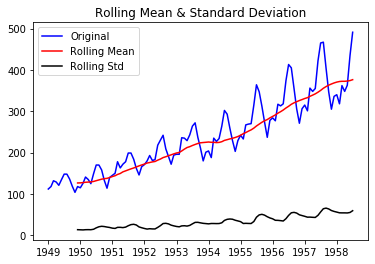

Test Statistic                  -0.356889
p-value                          0.917052
#Lags Used                      13.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [4]:
test_stationarity(df_train, "#Passengers", 12)

Obviously the figure above is not stationary since rolling std and mean are increasing. This was already expected because we saw a clear trend in the decomposition above.  


Next step is to check for the diff of the data.

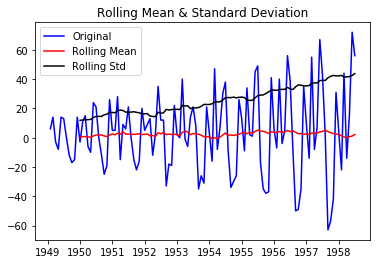

Test Statistic                  -2.539635
p-value                          0.106126
#Lags Used                      13.000000
Number of Observations Used    100.000000
Critical Value (1%)             -3.497501
Critical Value (5%)             -2.890906
Critical Value (10%)            -2.582435
dtype: float64


In [5]:
dfdiff = df_train.diff().dropna()
test_stationarity(dfdiff, "#Passengers", 12)

The mean looks pretty good since it is flat and smooth with now increase basically almost 0. 
However the data still increases in variance and thus std, that needs to be fixed.

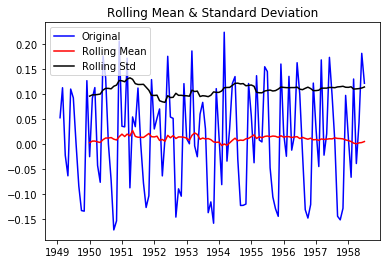

Test Statistic                  -2.635851
p-value                          0.085812
#Lags Used                      12.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [6]:
df_difflog = np.log(df_train).diff().dropna()
test_stationarity(df_difflog, "#Passengers", 12)

This is even better, the std is almost flat and the original data doesnt seem to have a trend anymore. 
Looking at the values from the dicky fuller test, we have a p-value of 0.7 which means we have to reject the null hypothesis and thus this is not a  stationary  data set, but it is really close though.

So we look at the PACF, ACF of the diff_log transformation

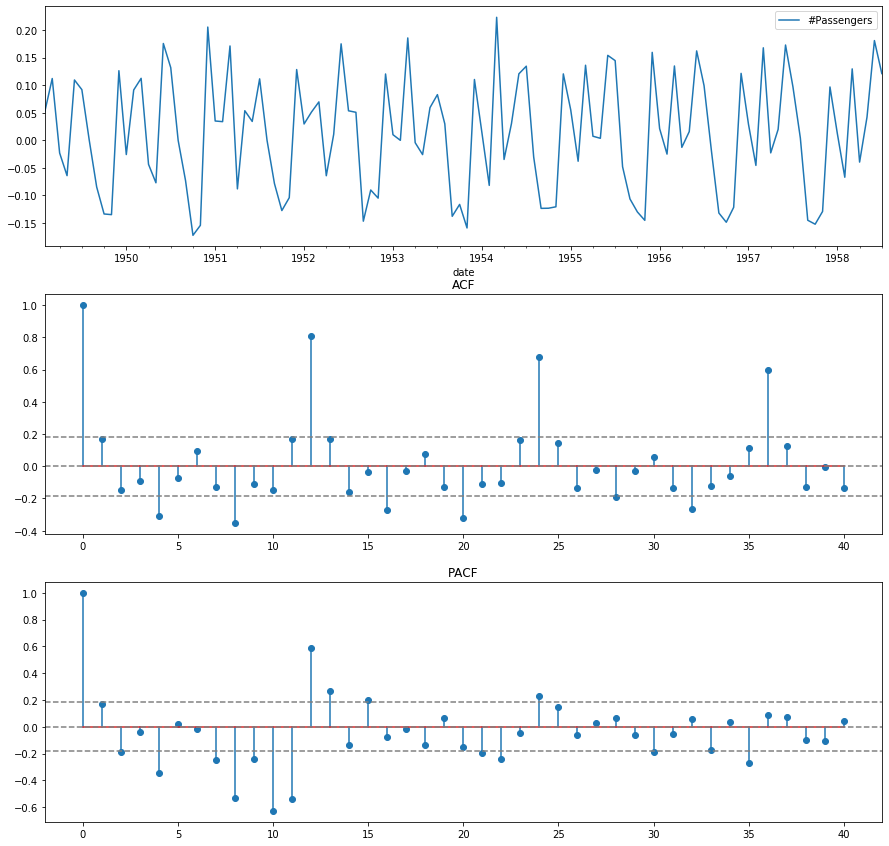

In [7]:
plots(df_difflog)

We notice that the first outbreak of ACF function seems to be at mark 1 . Furthermore the seasonality seems to be 12, 24, 36 so yearly.
This is suggesting q=(1) the seasonality peeks indicate Q=(2,3)

For the PAC we see outbreaks at 1 and so on. Seasonality here seems to be indicated for 12,24 for 36 it isnt visible.
This indicates p >= 1, and Seasonality more towards P= 2 not really 3

lag is 1 



In [8]:
# search optimal model
# p value is of Ljung–Box test (hypothesis: data is independent)
# when p value smaller < 0.5 then we reject null hypothesis

#cust_sarimax(np.log(df_train),[0,1,2],[0,1],[1,2],[0,1,2],[0,1],[0,1,2],[12],maxorder=6)

found optimal model for values: AIC (1, 0, 1, 1, 0, 1, 12) BIC (0, 1, 1, 1, 0, 1, 12)

Next up is a cross validation with a TimeSeriesSplitter to see how it behaves over time on the training data

In [95]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# we use the default of 5 splits
tss = TimeSeriesSplit()

all_scores = []
all_scores3 = []
all_scores6 = []

for train_index, test_index in tss.split(df_train):
    tr, te = df_train.iloc[train_index,:], df_train.iloc[test_index,:]
    m_sarimax = SARIMAX(np.log(tr), order=(0, 1, 1), seasonal_order=(1, 0, 1, 12), enforce_invertibility=False,
            enforce_stationarity=False)
    r_sarmiax = m_sarimax.fit(disp=0)
    
    predict = np.exp(r_sarmiax.forecast(len(te.index)))
    
    rmse = np.sqrt(mean_squared_error(te["#Passengers"].values, predict))
    rmse3 = np.sqrt(mean_squared_error(te["#Passengers"].values[:3], predict[:3]))
    rmse6 = np.sqrt(mean_squared_error(te["#Passengers"].values[:6], predict[:6]))
    
    all_scores.append(rmse)
    all_scores3.append(rmse3)
    all_scores6.append(rmse6)
    
print("Baseline on training data (all): ", np.mean(np.array(all_scores)), all_scores)
print("Baseline on training data (3): ", np.mean(np.array(all_scores3)), all_scores3)
print("Baseline on training data (6): ", np.mean(np.array(all_scores6)), all_scores6)

    

Baseline on training data (all):  21.08520430696002 [25.18489349649665, 15.633728703999703, 17.445069005532172, 22.05714915007314, 25.105181178698437]
Baseline on training data (3):  13.144183250347126 [9.898307414833377, 10.803991836189525, 15.107884848788363, 24.4072378917846, 5.5034942601397585]
Baseline on training data (6):  15.674096862041594 [16.272880629435345, 12.366047725472436, 23.974284024354997, 19.29551717532692, 6.461754755618276]


Baseline on test data (all): 15.099579280027104
Baseline on test data (3): 17.08185190357965
Baseline on test data (6): 16.5103785876859


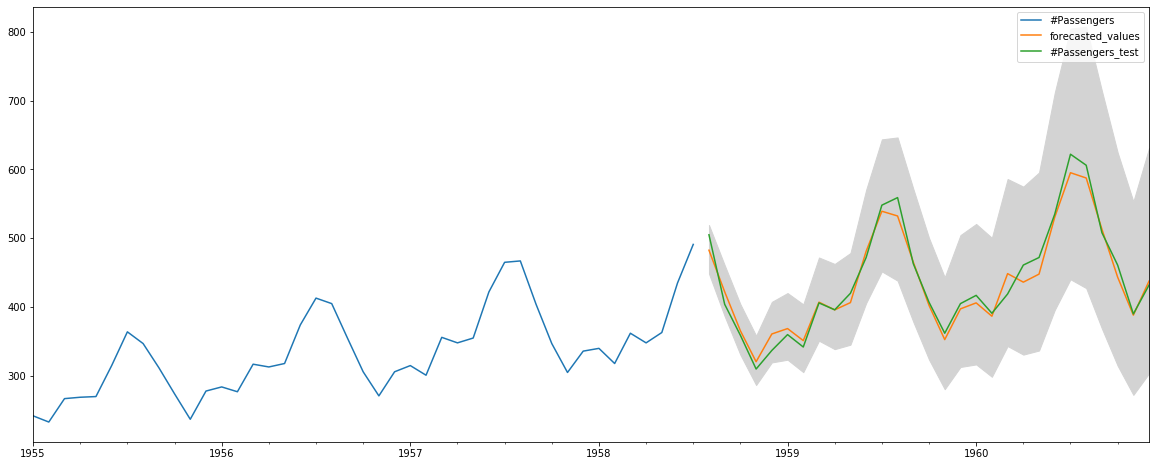

In [134]:

m_sarimax = SARIMAX(np.log(df_train), order=(0, 1, 1), seasonal_order=(1, 0, 1, 12), enforce_invertibility=False,
            enforce_stationarity=False)
r_sarmiax = m_sarimax.fit(disp=0)

confidence = np.exp(r_sarmiax.get_forecast(len(df_test.index)).conf_int(alpha=.05))
confidence.columns = ["lowerCI","upperCI"]

series_SARIMAX = np.exp(r_sarmiax.forecast(len(df_test.index)))

df_sarimax = pd.DataFrame(series_SARIMAX)
df_sarimax.columns = ["forecasted_values"]

df_sarimax =  df_sarimax.join(confidence)

df_subtotal = df_train.join(df_sarimax, how="outer")
#print(df_subtotal.columns)

df_subtotal = df_subtotal.join(df_test, how="left", rsuffix="_test")

df_subtotal[['#Passengers', 'forecasted_values', '#Passengers_test']][int(-1*(len(df_test.index)*2.5)):].plot(figsize=(20,8))


plt.fill_between(df_subtotal.index, df_subtotal.lowerCI, df_subtotal.upperCI, color="lightgrey")


# calculate baseline on test data
print("Baseline on test data (all):", np.sqrt(mean_squared_error(df_test["#Passengers"].values, series_SARIMAX.values)))
print("Baseline on test data (3):", np.sqrt(mean_squared_error(df_test["#Passengers"].values[:3], series_SARIMAX.values[:3])))
print("Baseline on test data (6):", np.sqrt(mean_squared_error(df_test["#Passengers"].values[:6], series_SARIMAX.values[:6])))

# Exponential Smoothing

First we grid search Holt Winter. Then we will cross validate one last time manually before applying the test data

In [128]:


grid_trend = ["add","mul",None]
grid_damped = [True, False]
grid_seasonal = ["add","mul",None]
grid_seasonal_periods = [12]


best_rmse = [10000000 for i in range(3)]
best_params = [foo, foo, foo]

for g_trend in grid_trend:
    for g_damped in grid_damped:
        for g_seasonal in grid_seasonal:
            for g_seasonal_periods in grid_seasonal_periods:
                
                tss = TimeSeriesSplit()
                
                all_rmse = []
                all_rmse3 = []
                all_rmse6 = []
                
                for tr_i, te_i in tss.split(df_train):
                    
                    try:
                    
                        tr, te = df_train.iloc[tr_i,:], df_train.iloc[te_i,:]
                        
                        m_hw = ExponentialSmoothing(tr, trend=g_trend, damped=g_damped, seasonal=g_seasonal, seasonal_periods=g_seasonal_periods)
                        r_hw = m_hw.fit()
    
                        forecast_series = pd.DataFrame(r_hw.forecast(len(te.index)))
                        
                        rmse = np.sqrt(mean_squared_error(te["#Passengers"].values, forecast_series.values))
                        rmse3 = np.sqrt(mean_squared_error(te["#Passengers"].values[:3], forecast_series.values[:3]))
                        rmse6 = np.sqrt(mean_squared_error(te["#Passengers"].values[:6], forecast_series.values[:6]))
                    
                        all_rmse.append(rmse)
                        all_rmse3.append(rmse3)
                        all_rmse6.append(rmse6)
                        
                    except:
                        pass
                    
                if np.mean(all_rmse) < best_rmse[0]:
                    best_rmse[0] = np.mean(all_rmse)
                    best_params[0] = (g_trend, g_damped, g_seasonal, g_seasonal_periods)
                        
                if np.mean(all_rmse3) < best_rmse[1]:
                    best_rmse[1] = np.mean(all_rmse3)
                    best_params[1] = (g_trend, g_damped, g_seasonal, g_seasonal_periods)
                        
                if np.mean(all_rmse6) < best_rmse[2]:
                    best_rmse[2] = np.mean(all_rmse6)
                    best_params[2] = (g_trend, g_damped, g_seasonal, g_seasonal_periods)
                    
                        
print("Baseline for training data:", best_rmse)
print(best_params)


Baseline for training data: [17.395226332778854, 11.607437108956848, 13.949063354561535]
[('mul', False, 'mul', 12), (None, False, 'mul', 12), ('mul', False, 'mul', 12)]


For all RMSE and 6 days RMSE  the model with paramters set mul, false, mul, 12 seem to be the best. So we just take it since there is no special requirement definded.

However I would always have the requirement in the back of my mind when doing these cross validation analysis.  
It might be you have a model that performs very bad over 12 periods but is extremly good for the next 3 months, then this is more suited for you than a general good working model that has its strenght in areas you customer doesn't need 

Baseline on test data (all): 13.188166077669207
Baseline on test data (3): 16.169668544735956
Baseline on test data (6): 12.290407288708062


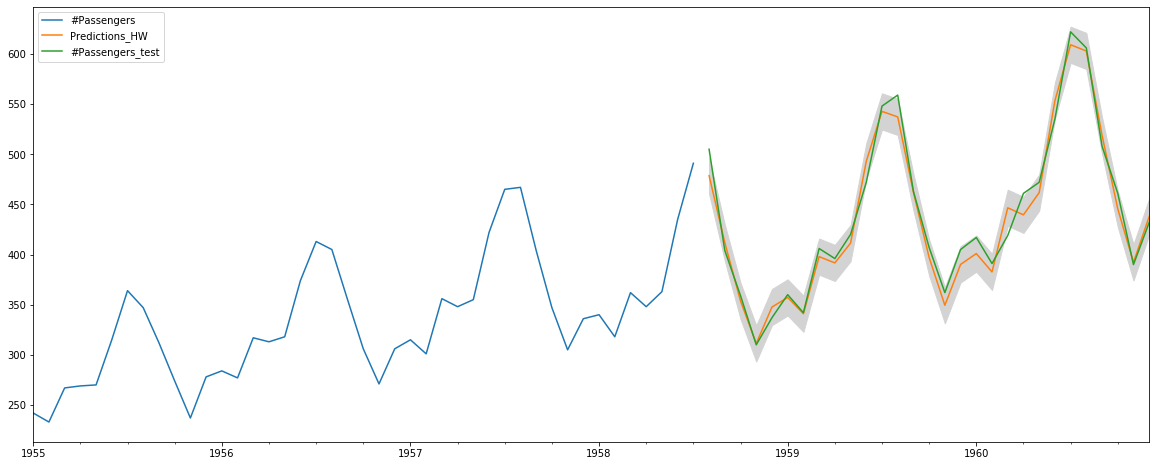

In [136]:
#applying holt winter to it

m_hw = ExponentialSmoothing(df_train, trend="mul", damped=False, seasonal="mul", seasonal_periods=12)
r_hw = m_hw.fit()

df_holt = pd.DataFrame(r_hw.forecast(len(df_test.index)))

std = np.std( r_hw.resid)
conf_intervall = 0.95
zlookup = st.norm.ppf(1-(1-conf_intervall)/2)
foo = std * zlookup

df_holt.columns = ["Predictions_HW"]

df_holt["upperCI_HW"] = df_holt.Predictions_HW + foo
df_holt["lowerCI_HW"] = df_holt.Predictions_HW - foo

df_subtotal = df_train.join(df_holt, how="outer")

df_subtotal = df_subtotal.join(df_test[["#Passengers"]],how="left",rsuffix="_test")

df_subtotal[["#Passengers","Predictions_HW","#Passengers_test"]][int(-1*(len(df_test.index)*2.5)):].plot(figsize=(20,8))
plt.fill_between(df_subtotal.index, df_subtotal.lowerCI_HW, df_subtotal.upperCI_HW, color="lightgrey")

# calculate baseline on test data
print("Baseline on test data (all):", np.sqrt(mean_squared_error(df_test["#Passengers"].values, df_holt["Predictions_HW"].values)))
print("Baseline on test data (3):", np.sqrt(mean_squared_error(df_test["#Passengers"].values[:3], df_holt["Predictions_HW"].values[:3])))
print("Baseline on test data (6):", np.sqrt(mean_squared_error(df_test["#Passengers"].values[:6], df_holt["Predictions_HW"].values[:6])))

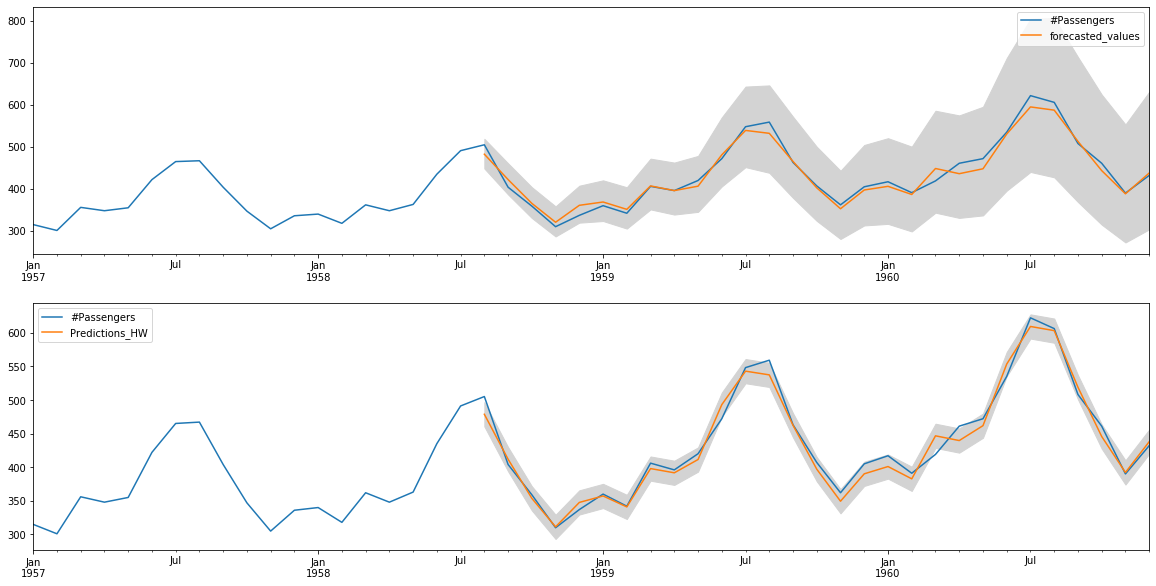

In [137]:

#df_2018_check = df[:"2018-12-01"].copy()
df_2018_check = df.copy()
df_2018_check = df_2018_check.join(df_sarimax, how="outer")
df_2018_check = df_2018_check.join(df_holt, how="outer")



ax1 = plt.subplot(211)

df_2018_check["1957-01-01":][['#Passengers', 'forecasted_values']].plot(figsize=(20,10),ax=ax1)
ax1.fill_between(df_2018_check.index, df_2018_check.lowerCI, df_2018_check.upperCI, color="lightgrey")

ax2 = plt.subplot(212)

df_2018_check["1957-01-01":][["#Passengers","Predictions_HW"]].plot(figsize=(20,10),ax=ax2)
ax2.fill_between(df_2018_check.index, df_2018_check.lowerCI_HW, df_2018_check.upperCI_HW, color="lightgrey")

In [138]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

df_2018_check["SARIMAX_off_percent"] = round(abs(df_2018_check["#Passengers"] - df_2018_check["forecasted_values"]) / df_2018_check["#Passengers"] * 100,2)
df_2018_check["HoltWinter_off_percent"] = round(abs(df_2018_check["#Passengers"] - df_2018_check["Predictions_HW"]) / df_2018_check["#Passengers"] * 100,2)

df_2018_check["SARIMAX_rse"] = np.sqrt((df_2018_check["#Passengers"] - df_2018_check["forecasted_values"]) ** 2)
df_2018_check["HW_rse"] = np.sqrt((df_2018_check["#Passengers"] - df_2018_check["Predictions_HW"]) ** 2)


print("RMSE SARIMAX: {}".format(np.sqrt(((df_2018_check["#Passengers"] - df_2018_check["forecasted_values"]) ** 2).mean())))
print("RMSE HW: {}".format(np.sqrt(((df_2018_check["#Passengers"] - df_2018_check["Predictions_HW"]) ** 2).mean())))

df_2018_check["1959-01-01":][["#Passengers","forecasted_values","Predictions_HW","SARIMAX_off_percent","HoltWinter_off_percent","SARIMAX_rse","HW_rse"]]


RMSE SARIMAX: 15.099579280027104
RMSE HW: 13.18816607766921


,#Passengers,forecasted_values,Predictions_HW,SARIMAX_off_percent,HoltWinter_off_percent,SARIMAX_rse,HW_rse
1959-01-01,360,368.762,357.244,2.430,0.770,8.762,2.756
1959-02-01,342,351.272,340.966,2.710,0.300,9.272,1.034
1959-03-01,406,407.092,397.923,0.270,1.990,1.092,8.077
1959-04-01,396,395.931,391.651,0.020,1.100,0.069,4.349
1959-05-01,420,406.470,411.398,3.220,2.050,13.530,8.602
1959-06-01,472,481.095,492.975,1.930,4.440,9.095,20.975
1959-07-01,548,539.198,542.746,1.610,0.960,8.802,5.254
1959-08-01,559,532.286,537.211,4.780,3.900,26.714,21.789
1959-09-01,463,465.266,462.236,0.490,0.170,2.266,0.764
1959-10-01,407,402.505,396.991,1.100,2.460,4.495,10.009


So overall the SARIMAX and HW have only a RMSE difference of 2.5 which is pretty good.  
Looking at the graphs Holt Winter seems to catch it quite a bit better tan SARIMAX but the baseline is around RSME of 15

So we have baseline on test data of average 14 RMSE and on train data of ~14 (HW) and 20 (SARIMA)

# RNN (recurrent neural network) LSTM

next up we use the classical LSTM network by using deep layers.

The downside of this is that we can only forecast the very next datapoint, we are unable to forecast a sequence.

In [75]:

import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error




In [76]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)


For LSTM layers to receive data it needs to be shaped like (#observations, #timesteps, #features).

This means we have to do lag calculation in order to shape the data like mentioned above.  
The underlying function create_dataset is creating such a shape (#observations, look_back, 1).  
The number of features is 1 because we have univariate time series and thus #Passengers is our only feature.

Next we split the data set into train and test set 80/20

In [77]:

from sklearn.model_selection import train_test_split
lag=3

dfexp = df.copy()

for i in range(lag):
    colname = "shift_{}".format(i+1)
    dfexp[colname] = dfexp["#Passengers"].shift(i+1)
    
X, y = create_dataset(df.values, 3)

# split 

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15,shuffle=False)

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)


# adam loss: 12.6657 - val_loss: 37.1956

In [78]:

from keras.callbacks import ReduceLROnPlateau, EarlyStopping

lr = EarlyStopping(patience=1000, restore_best_weights=True,monitor='loss')

# univariate lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
# define dataset
#X = array([[10, 20, 30], [20, 30, 40], [30, 40, 50], [40, 50, 60]])
#y = array([40, 50, 60, 70])
# reshape from [samples, timesteps] into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(3, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=["mape","mae"])
# fit model
history = model.fit(X_train, y_train, epochs=1000, verbose=True, callbacks=[lr])
#model.fit(X, y, epochs=1000, verbose=True, validation_split=0.2)
# demonstrate prediction
x_input = X_test
x_input = x_input.reshape((x_input.shape[0], x_input.shape[1], 1))
yhat = model.predict(x_input, verbose=0)
print(yhat, y[12])


Epoch 1/1000
119/119 [==============================] - 0s 3ms/step - loss: 72932.8069 - mape: 100.9836 - mae: 253.1583
Epoch 2/1000
119/119 [==============================] - 0s 120us/step - loss: 67912.4261 - mape: 97.6838 - mae: 244.5366
Epoch 3/1000
119/119 [==============================] - 0s 146us/step - loss: 64182.3436 - mape: 94.8474 - mae: 237.5913
Epoch 4/1000
119/119 [==============================] - 0s 131us/step - loss: 61447.7858 - mape: 92.6787 - mae: 232.2852
Epoch 5/1000
119/119 [==============================] - 0s 171us/step - loss: 59462.0134 - mape: 90.9937 - mae: 228.2897
Epoch 6/1000
119/119 [==============================] - 0s 137us/step - loss: 57691.1354 - mape: 89.5412 - mae: 224.7791
Epoch 7/1000
119/119 [==============================] - 0s 148us/step - loss: 55966.9949 - mape: 87.9165 - mae: 221.0719
Epoch 8/1000
119/119 [==============================] - 0s 132us/step - loss: 53435.2267 - mape: 85.4509 - mae: 215.4276
Epoch 9/1000
119/119 [===========

119/119 [==============================] - 0s 138us/step - loss: 620.4057 - mape: 7.7898 - mae: 19.4764
Epoch 139/1000
119/119 [==============================] - 0s 147us/step - loss: 628.4794 - mape: 8.3990 - mae: 20.2445
Epoch 140/1000
119/119 [==============================] - 0s 148us/step - loss: 563.8158 - mape: 7.6949 - mae: 18.6927
Epoch 141/1000
119/119 [==============================] - 0s 189us/step - loss: 586.3676 - mape: 7.5474 - mae: 18.7117
Epoch 142/1000
119/119 [==============================] - 0s 153us/step - loss: 568.9612 - mape: 7.8066 - mae: 18.9385
Epoch 143/1000
119/119 [==============================] - 0s 156us/step - loss: 561.2217 - mape: 7.7149 - mae: 18.7168
Epoch 144/1000
119/119 [==============================] - 0s 157us/step - loss: 589.4307 - mape: 7.6153 - mae: 18.9156
Epoch 145/1000
119/119 [==============================] - 0s 163us/step - loss: 574.9729 - mape: 7.8165 - mae: 18.9353
Epoch 146/1000
119/119 [==============================] - 0s 17

Epoch 207/1000
119/119 [==============================] - 0s 135us/step - loss: 534.5291 - mape: 7.3792 - mae: 17.8959
Epoch 208/1000
119/119 [==============================] - 0s 144us/step - loss: 542.9517 - mape: 7.6495 - mae: 18.3354
Epoch 209/1000
119/119 [==============================] - 0s 137us/step - loss: 516.3901 - mape: 7.4572 - mae: 17.8847
Epoch 210/1000
119/119 [==============================] - 0s 156us/step - loss: 516.8472 - mape: 7.5004 - mae: 17.8796
Epoch 211/1000
119/119 [==============================] - 0s 150us/step - loss: 512.1519 - mape: 7.2551 - mae: 17.4779
Epoch 212/1000
119/119 [==============================] - 0s 157us/step - loss: 511.7119 - mape: 7.2641 - mae: 17.5663
Epoch 213/1000
119/119 [==============================] - 0s 165us/step - loss: 509.1658 - mape: 7.3601 - mae: 17.6373
Epoch 214/1000
119/119 [==============================] - 0s 158us/step - loss: 518.6697 - mape: 7.5131 - mae: 18.1396
Epoch 215/1000
119/119 [========================

Epoch 344/1000
119/119 [==============================] - 0s 187us/step - loss: 498.0549 - mape: 7.4553 - mae: 17.9427
Epoch 345/1000
119/119 [==============================] - 0s 156us/step - loss: 472.8876 - mape: 7.3015 - mae: 17.4298
Epoch 346/1000
119/119 [==============================] - 0s 158us/step - loss: 468.8622 - mape: 7.4516 - mae: 17.5689
Epoch 347/1000
119/119 [==============================] - 0s 173us/step - loss: 465.9180 - mape: 7.3268 - mae: 17.4812
Epoch 348/1000
119/119 [==============================] - 0s 179us/step - loss: 480.1019 - mape: 7.4307 - mae: 17.8221
Epoch 349/1000
119/119 [==============================] - 0s 158us/step - loss: 492.3324 - mape: 7.4316 - mae: 17.8177
Epoch 350/1000
119/119 [==============================] - 0s 155us/step - loss: 460.0252 - mape: 7.2188 - mae: 17.2321
Epoch 351/1000
119/119 [==============================] - 0s 170us/step - loss: 476.0875 - mape: 7.3608 - mae: 17.5405
Epoch 352/1000
119/119 [========================

Epoch 481/1000
119/119 [==============================] - 0s 254us/step - loss: 424.8755 - mape: 7.2262 - mae: 16.9436
Epoch 482/1000
119/119 [==============================] - 0s 221us/step - loss: 423.2516 - mape: 7.0879 - mae: 16.7780
Epoch 483/1000
119/119 [==============================] - 0s 210us/step - loss: 411.9418 - mape: 7.0613 - mae: 16.5716
Epoch 484/1000
119/119 [==============================] - 0s 181us/step - loss: 418.0999 - mape: 7.1933 - mae: 16.8474
Epoch 485/1000
119/119 [==============================] - 0s 170us/step - loss: 423.0847 - mape: 7.2302 - mae: 16.9546
Epoch 486/1000
119/119 [==============================] - 0s 195us/step - loss: 423.8219 - mape: 7.1081 - mae: 16.7809
Epoch 487/1000
119/119 [==============================] - 0s 212us/step - loss: 414.0213 - mape: 7.1066 - mae: 16.6667
Epoch 488/1000
119/119 [==============================] - 0s 244us/step - loss: 411.6453 - mape: 7.1749 - mae: 16.7520
Epoch 489/1000
119/119 [========================

Epoch 618/1000
119/119 [==============================] - 0s 135us/step - loss: 494.9465 - mape: 7.4637 - mae: 18.1082
Epoch 619/1000
119/119 [==============================] - 0s 136us/step - loss: 498.7689 - mape: 7.4939 - mae: 18.0464
Epoch 620/1000
119/119 [==============================] - 0s 135us/step - loss: 517.4476 - mape: 7.5236 - mae: 18.4032
Epoch 621/1000
119/119 [==============================] - 0s 136us/step - loss: 540.2416 - mape: 7.5804 - mae: 18.5526
Epoch 622/1000
119/119 [==============================] - 0s 126us/step - loss: 503.6837 - mape: 7.4789 - mae: 17.9987
Epoch 623/1000
119/119 [==============================] - 0s 129us/step - loss: 497.3569 - mape: 7.4573 - mae: 18.0058
Epoch 624/1000
119/119 [==============================] - 0s 143us/step - loss: 470.7964 - mape: 7.3256 - mae: 17.6865
Epoch 625/1000
119/119 [==============================] - 0s 150us/step - loss: 470.0842 - mape: 7.2802 - mae: 17.5792
Epoch 626/1000
119/119 [========================

Epoch 755/1000
119/119 [==============================] - 0s 117us/step - loss: 384.0621 - mape: 6.7011 - mae: 15.6659
Epoch 756/1000
119/119 [==============================] - 0s 214us/step - loss: 384.6003 - mape: 6.6785 - mae: 15.7181
Epoch 757/1000
119/119 [==============================] - 0s 165us/step - loss: 391.5644 - mape: 6.7216 - mae: 15.9433
Epoch 758/1000
119/119 [==============================] - 0s 153us/step - loss: 385.3412 - mape: 6.6751 - mae: 15.7415
Epoch 759/1000
119/119 [==============================] - 0s 146us/step - loss: 389.1388 - mape: 6.6821 - mae: 15.7322
Epoch 760/1000
119/119 [==============================] - 0s 147us/step - loss: 397.1395 - mape: 6.8837 - mae: 16.1288
Epoch 761/1000
119/119 [==============================] - 0s 158us/step - loss: 384.6029 - mape: 6.6028 - mae: 15.6712
Epoch 762/1000
119/119 [==============================] - 0s 164us/step - loss: 382.7268 - mape: 6.5257 - mae: 15.5808
Epoch 763/1000
119/119 [========================

Epoch 892/1000
119/119 [==============================] - 0s 162us/step - loss: 344.9376 - mape: 6.4435 - mae: 14.8432
Epoch 893/1000
119/119 [==============================] - 0s 150us/step - loss: 339.6329 - mape: 6.4685 - mae: 14.8090
Epoch 894/1000
119/119 [==============================] - 0s 158us/step - loss: 351.4541 - mape: 6.5431 - mae: 15.1126
Epoch 895/1000
119/119 [==============================] - 0s 159us/step - loss: 329.7025 - mape: 6.3180 - mae: 14.4698
Epoch 896/1000
119/119 [==============================] - 0s 172us/step - loss: 346.2097 - mape: 6.4255 - mae: 14.7291
Epoch 897/1000
119/119 [==============================] - 0s 194us/step - loss: 360.4225 - mape: 6.7424 - mae: 15.4611
Epoch 898/1000
119/119 [==============================] - 0s 172us/step - loss: 339.9552 - mape: 6.3589 - mae: 14.6177
Epoch 899/1000
119/119 [==============================] - 0s 160us/step - loss: 361.0800 - mape: 6.6365 - mae: 15.2633
Epoch 900/1000
119/119 [========================

Lets now monitor the loss curve for training 

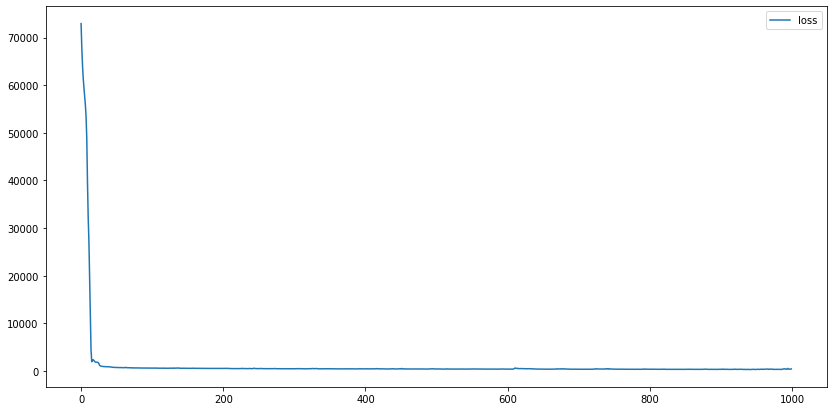

In [80]:
pd.DataFrame.from_dict(history.history)[["loss"]].plot(figsize=(14,7))

The learning took a huge step in the beginning but then basically stagnated. 

It could be smoothened out a bit by scaling the input with a minmax or standard scaler first

Test Score: 43.54 RMSE


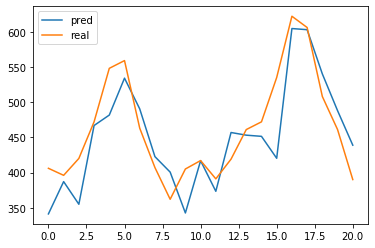

In [87]:
yhat = yhat.reshape(yhat.shape[0])


testScore = math.sqrt(mean_squared_error(y_test, yhat))
print('Test Score: %.2f RMSE' % (testScore))

pd.DataFrame.from_dict({ "pred": yhat, "real":y_test}).plot()

The result looks ok but the detauls couldnt be catched by the simple RNN.

Also we have to remind ourselves that this is a one-step-ahead predictions and for that an RMSE of 43 is pretty bad and definetly worse than our baseline with SARIMA and HW.

# RNN with deep architecture

We take the same example like above from the non deep RNN and add optional layer size for LSTM and Dense part.

Then we are doing a gridsearchCV custom implementation. Each parameter set is cross validated with TimeSeriesSplit wich is splitting the series cronologically. The mean of that CV will then be the measure for that parameter set

In [104]:
import numpy as np



def RNN_GridSearch(lstmlayers, denselayers, lag):
    from sklearn.model_selection import train_test_split
    
    dfexp = df.copy()
    
    for i in range(lag):
        colname = "shift_{}".format(i+1)
        dfexp[colname] = dfexp["#Passengers"].shift(i+1)
        
    X, y = create_dataset(df.values, lag)
    
    
    #X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15,shuffle=False)
    
    from sklearn.model_selection import TimeSeriesSplit
    
    tss =TimeSeriesSplit()
    
    allscores = []
    
    for trai_i, tes_i in tss.split(X):
        X_train, y_train = X[trai_i,:], y[trai_i]
        X_test, y_test = X[tes_i,:], y[tes_i]
    
        X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
        from keras.callbacks import ReduceLROnPlateau, EarlyStopping
        
        lr = EarlyStopping(patience=1000, restore_best_weights=True,monitor='loss')
        
        # univariate lstm example
        from numpy import array
        from keras.models import Sequential
        from keras.layers import LSTM
        from keras.layers import Dense
        # define dataset
        #X = array([[10, 20, 30], [20, 30, 40], [30, 40, 50], [40, 50, 60]])
        #y = array([40, 50, 60, 70])
        # reshape from [samples, timesteps] into [samples, timesteps, features]
        X = X.reshape((X.shape[0], X.shape[1], 1))
        # define model
        model = Sequential()
        
        for i in range(len(lstmlayers)):
            node = LSTM(lstmlayers[i], activation = 'relu')
            if i == 0:
                node = LSTM(lstmlayers[i], activation = 'relu',input_shape = (lag,1))
            if i+1 < len(lstmlayers):
                node = LSTM(lstmlayers[i], activation = 'relu',return_sequences = True)
            
            model.add(node)
            
        for i in range(len(denselayers)):
            node = Dense(denselayers[i])
            model.add(node)
            
        model.compile(optimizer='adam', loss='mse', metrics=["mape","mae"])
        # fit model
        history = model.fit(X_train, y_train, epochs=100, verbose=0, callbacks=[lr])
        #model.fit(X, y, epochs=1000, verbose=True, validation_split=0.2)
        # demonstrate prediction
        x_input = X_test
        x_input = x_input.reshape((x_input.shape[0], x_input.shape[1], 1))
        yhat = model.predict(x_input, verbose=0)
        
        yhat = yhat.reshape(yhat.shape[0])
        
        
        testScore = math.sqrt(mean_squared_error(y_test, yhat))
        allscores.append(testScore)
        
    print('Test Score: %.2f RMSE' % (np.mean(allscores)))
    return np.mean(allscores), model, yhat



lstm = [[64,32,16,8], [32,16,8],[16,8],[8]]
dense = [[200,100,50,20,1],[100,50,20,1],[50,20,1],[20,1],[1]]
lookback = [3,6,12]

best_rmse = 1000000
pset = (0,0,0)
best_model = None
best_series = None

for l in lstm:
    for d in dense:
        for lo in lookback:
            rmse,m,s  = RNN_GridSearch(l,d,lo)
            if rmse < best_rmse:
                best_rmse = rmse
                pset = (l,d,lo)
                best_model = m
                best_series = s
                
print(best_rmse, pset)


Test Score: 35.59 RMSE
Test Score: 41.15 RMSE
Test Score: 31.25 RMSE
Test Score: 32.08 RMSE
Test Score: 42.81 RMSE
Test Score: 66.76 RMSE
Test Score: 37.39 RMSE
Test Score: 38.50 RMSE
Test Score: 29.60 RMSE
Test Score: 37.98 RMSE
Test Score: 44.83 RMSE
Test Score: 30.62 RMSE
Test Score: 35.19 RMSE
Test Score: 45.88 RMSE
Test Score: 43.82 RMSE
Test Score: 41.47 RMSE
Test Score: 38.62 RMSE
Test Score: 36.68 RMSE
Test Score: 42.85 RMSE
Test Score: 35.56 RMSE
Test Score: 37.63 RMSE
Test Score: 39.08 RMSE
Test Score: 39.13 RMSE
Test Score: 39.94 RMSE
Test Score: 36.87 RMSE
Test Score: 35.09 RMSE
Test Score: 55.65 RMSE
Test Score: 37.41 RMSE
Test Score: 33.22 RMSE
Test Score: 39.41 RMSE
Test Score: 39.96 RMSE
Test Score: 59.28 RMSE
Test Score: 47.99 RMSE
Test Score: 42.71 RMSE
Test Score: 39.09 RMSE
Test Score: 33.33 RMSE
Test Score: 37.68 RMSE
Test Score: 42.51 RMSE
Test Score: 47.48 RMSE
Test Score: 41.76 RMSE
Test Score: 107.21 RMSE
Test Score: 93.44 RMSE
Test Score: 103.86 RMSE
Test Scor

In [106]:

#yhat = yhat.reshape(yhat.shape[0])
yhat = best_series

testScore = math.sqrt(mean_squared_error(y_test, yhat))
print('Test Score: %.2f RMSE' % (testScore))


Test Score: 36.10 RMSE


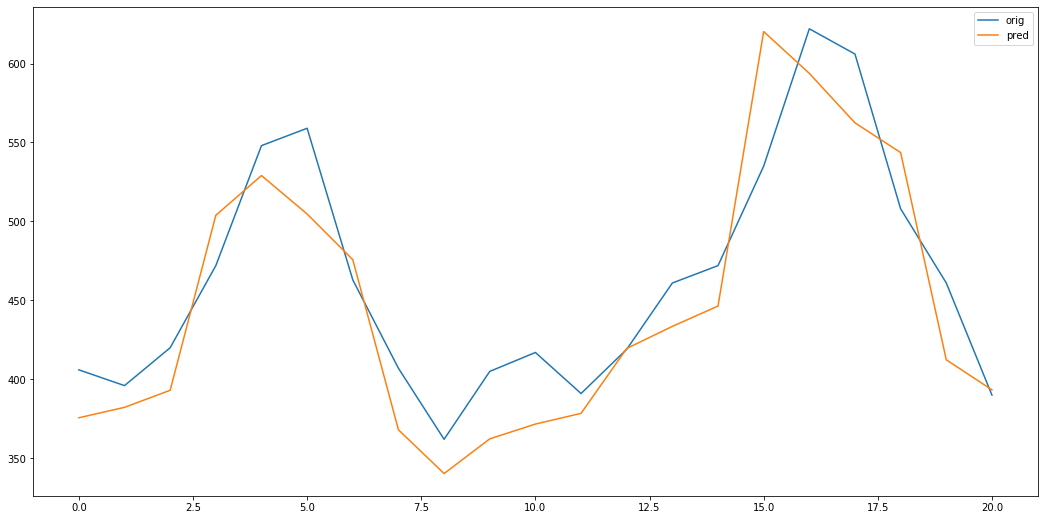

In [110]:
## 29.595806822540588 ([64, 32, 16, 8], [50, 20, 1], 12)
pd.DataFrame.from_dict({"orig":y_test, "pred": best_series}).plot(figsize=(18,9))

As we can see this is a better result than the single layer RNN network but still worse than the ARIMA/HW baseline

# MLP (Dense NN) with large window

Here we try a regular MLP by using lag data as feature set.  
Naturally with this approach we can only generate the next forecast and we will see that is not that promising.

In [111]:
df_w = df.copy()

# add 24 lags
for i in range(1,48):
    colname = "lag_{}".format(i)
    df_w[colname] = df_w["#Passengers"].shift(i)
    
df_w = df_w.dropna()

# add more data like day of week, month number etc

df_w["month"] = df_w.index.month
df_w["year"] = df_w.index.year

# use 20% of the data for testing
sentinel = int(.8 * len(df_w.index))


df_train = df_w.iloc[:sentinel,:]
df_test = df_w.iloc[sentinel:,:]



df_train.head()
    


,#Passengers,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,month,year
date,,,,,,,,,,,,,,,,,,,,,
1952-12-01,194,172.0,191.0,209.0,242.0,230.0,218.0,183.0,181.0,193.0,...,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0,12,1952
1953-01-01,196,194.0,172.0,191.0,209.0,242.0,230.0,218.0,183.0,181.0,...,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0,1,1953
1953-02-01,196,196.0,194.0,172.0,191.0,209.0,242.0,230.0,218.0,183.0,...,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,2,1953
1953-03-01,236,196.0,196.0,194.0,172.0,191.0,209.0,242.0,230.0,218.0,...,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,3,1953
1953-04-01,235,236.0,196.0,196.0,194.0,172.0,191.0,209.0,242.0,230.0,...,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,4,1953


We are scaling the whole testset using a Minmax Scaler

In [176]:
scaler = MinMaxScaler(feature_range=(0,1))

train = scaler.fit_transform(df_train)
test = scaler.transform(df_test)

X_train, y_train = train[:,1:], train[:,:1]
X_test, y_test = test[:,1:], test[:,:1]

X_test


array([[0.67267267, 0.7027027 , 0.51051051, 0.56456456, 0.4954955 ,
        0.41441441, 0.56156156, 0.6966967 , 1.04388715, 1.08135593,
        0.89189189, 0.65448505, 0.62928349, 0.6728972 , 0.53582555,
        0.60436137, 0.59190031, 0.4953271 , 0.62616822, 0.80373832,
        1.00626959, 1.1557971 , 1.03358209, 0.78754579, 0.7826087 ,
        0.80936455, 0.62541806, 0.6722408 , 0.64214047, 0.52508361,
        0.64214047, 0.80602007, 0.97324415, 1.15      , 1.04      ,
        0.816     , 0.80384615, 0.81923077, 0.66538462, 0.69230769,
        0.66923077, 0.51153846, 0.65384615, 0.8       , 0.93461538,
        1.23222749, 1.06565657, 0.36363636, 1.        ],
       [0.74474474, 0.67267267, 0.7027027 , 0.51051051, 0.56456456,
        0.4954955 , 0.41441441, 0.56156156, 0.72727273, 1.12881356,
        1.08108108, 0.89368771, 0.67601246, 0.62928349, 0.6728972 ,
        0.53582555, 0.60436137, 0.59190031, 0.4953271 , 0.62616822,
        0.80877743, 1.16304348, 1.19402985, 1.03296703, 0.8

In [177]:
y_train.shape

(77, 1)

The net will have 4 layers funneling from 200,100,20 to output 1  
We will reduce LR on plateau using a callback function. 

In [180]:
model=Sequential()
model.add(Dense(200,input_shape=(X_train.shape[1],),activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(100,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(20,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1,activation="sigmoid"))

from keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.001)
earlystop = EarlyStopping(monitor='loss', patience=5)

#model.compile(loss='mse', optimizer='adam') rmsprop
model.compile(loss='mse', optimizer='rmsprop', metrics=['mae']) 
history = model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=True, shuffle=False, callbacks = [reduce_lr])



Epoch 1/100
77/77 [==============================] - 0s 5ms/step - loss: 0.0436 - mae: 0.1719
Epoch 2/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0402 - mae: 0.1642
Epoch 3/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0291 - mae: 0.1346
Epoch 4/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0268 - mae: 0.1299
Epoch 5/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0245 - mae: 0.1273
Epoch 6/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0237 - mae: 0.1225
Epoch 7/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0193 - mae: 0.1090
Epoch 8/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0130 - mae: 0.0890
Epoch 9/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0114 - mae: 0.0811
Epoch 10/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0102 - mae: 0.0841
Epoch 11/100
77/77 [==============================] - 0s 2m

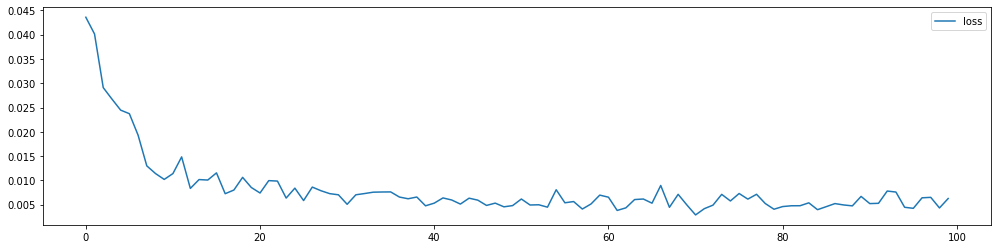

In [183]:
pd.DataFrame.from_dict(history.history)[["loss"]].plot(figsize=(17,4))

In [184]:
pred = model.predict(X_test)

print(pred)

result = []
for i in range(pred.shape[0]):
    val = pred[i][0]
    # create other 11 values as 0
    row = [val] + [0 for _ in range(49)]
    result.append(np.array(row))
pred2 = np.array(result)

_X = scaler.inverse_transform(pred2)

forecasts = [x[0] for x in _X]

print(forecasts)

pred_scaled = forecasts

result = []
for i in range(y_test.shape[0]):
    val = y_test[i][0]
    # create other 11 values as 0
    row = [val] + [0 for _ in range(49)]
    result.append(np.array(row))
y_test2 = np.array(result)
_X = scaler.inverse_transform(y_test2)

y_test3 = [x[0] for x in _X]

real = np.array(y_test3)
fc_y = np.array(pred_scaled)



np.sqrt(np.mean((real - fc_y)**2))



[[0.66478294]
 [0.8634175 ]
 [0.9324997 ]
 [0.9167447 ]
 [0.7682848 ]
 [0.5702497 ]
 [0.487058  ]
 [0.5267925 ]
 [0.59369355]
 [0.5577155 ]
 [0.6831499 ]
 [0.65576917]
 [0.7409564 ]
 [0.9056066 ]
 [0.9593781 ]
 [0.95101345]
 [0.83878666]
 [0.6527346 ]
 [0.52527016]
 [0.5891604 ]]
[396.05445593595505, 460.6106895208359, 483.062404692173, 477.9420304298401, 429.69255924224854, 365.3311449289322, 338.29385444521904, 351.2075710296631, 372.95040518045425, 361.25752955675125, 402.02370911836624, 393.124980032444, 420.81083834171295, 474.3221539258957, 491.7978900671005, 489.0793699026108, 452.60566502809525, 392.1387377381325, 350.7128033041954, 371.4771243929863]


61.42228166750813

As result we have 61 RMSE which is pretty bad, actually the worst result even especially knowing this is just a one step ahead forecast.

115
16
4
29
20
20
XX 20
20


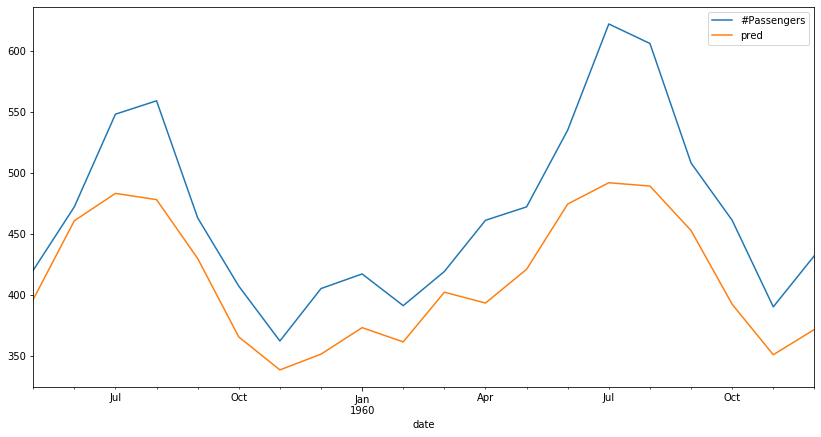

In [187]:
#testPredict = model.predict(testX)
#df.iloc[train_size:]["asdf"] = scaler.inverse_transform(testPredict)
print(train_size)
print(len(testPredict))
print(len(testX))
___d = (df.iloc[train_size:,:])
print(len(___d.index))
print(len(test))
print(len(fc_y))

cuts = -1 - look_back
''
_evaluate = df.iloc[train_size+9:,:]
print("XX {}".format(len(_evaluate.index)))
print(len(real))

_evaluate["pred"] = fc_y
#_evaluate

#pd.concat([df.iloc[:train_size,:], _evaluate])["1957-01-01":].plot(figsize=(20,10))
_evaluate.plot(figsize=(14,7))

We can see that the MLP is picking up on the seasonality but it clearly misses the trend, both precasted top points are on the same level, instead they should increase slightly as the trend is clearly linear.

## More complex Networks to come here, Seq2Seq